In [1]:
import pandas as pd

from glob import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

from scipy.stats import pearsonr, spearmanr

import itertools

from math import log

In [2]:
corrs = glob('/home/rdora/declaranet/data/corruption/encig*')

In [3]:
cnts = pd.read_csv('/home/rdora/declaranet/data/network/edge_list.csv',
                  parse_dates=['start_date'])

In [ ]:
cnts = cnts[cnts.st]

In [4]:
cnts_federal = pd.read_csv('/home/rdora/declaranet/data/network/edge_list_federal.csv',
                  parse_dates=['start_date'])

In [5]:
cnts_local = pd.read_csv('/home/rdora/declaranet/data/network/edge_list_local.csv',
                  parse_dates=['start_date'])

In [6]:
cnts = cnts[~cnts.supplier_state.str.contains('-')]

In [7]:
cols = ['state',
        'population',
        'very_high',
        'very_high_r',
        'high',
        'high_r',
        'low',
        'low_r',
        'very_low',
        'very_low_r']

digit = re.compile(r'\d+')

dfs = []
for file in corrs:
    year = int(digit.search(file).group())
    df = pd.read_csv(file, usecols=[0, 1, 3, 4, 6, 7, 9, 10, 12, 13])
    df.columns = cols
    df['state'] = df.state.replace({'Querétaro de Arteaga': 'Querétaro',
                                    'Distrito Federal': 'Ciudad de México',
                                    'Estado de México': 'México'})
    df['year'] = year
    dfs.append(df)
df = pd.concat(dfs)

In [8]:
def dispersion(states):
    
    return np.std(states) / np.mean(states)

# Federal level

In [9]:
cnts_federal['same_state'] = (cnts_federal['buyer_state'] == cnts_federal['supplier_state']) * 1

gb_cnts_federal = cnts_federal.groupby('buyer_state', as_index=False).agg(
    {'single_bid': 'mean',
     'file_size': lambda x: np.quantile(x, 0.9),
     'person': 'mean',
     'contract_duration': 'mean',
     'daily_price': 'mean',
     'same_state': 'mean',
     'amount': 'mean'})

# Buyer's variability

## Coefficient of variation

In [14]:
gb_states = cnts_federal.groupby('buyer_state')['supplier_state'].value_counts().rename('N').reset_index()
gb_states_n = cnts_federal.groupby('buyer_state').supplier_state.size().rename('NC').reset_index()
gb_states = gb_states[
    gb_states.buyer_state != gb_states.supplier_state].groupby(
    'buyer_state').N.apply(dispersion).rename('variation').reset_index()
gb_states = pd.merge(gb_states, gb_states_n, how='left')
gb_states['variation'] = gb_states['variation'] / gb_states['NC']
gb_states = gb_states.drop('NC', axis=1)

In [15]:
gb_cnts_federal = pd.merge(gb_cnts_federal, gb_states, how='left')

gb_cnts_federal = gb_cnts_federal.rename(columns={'buyer_state': 'state'})

gb_corr = df[df.year==2017].groupby(['state'], as_index=False).mean().drop(['high_r', 'low_r', 'year'], axis=1)

gb_cnts_federal = pd.merge(gb_corr, gb_cnts_federal, how='left')

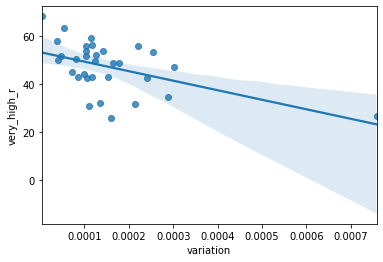

In [16]:
sns.regplot(x='variation', y='very_high_r', data=gb_cnts_federal)

# Local Level

In [18]:
cnts_local['same_state'] = (cnts_local['buyer_state'] == cnts_local['supplier_state']) * 1

gb_cnts_local = cnts_local.groupby('buyer_state', as_index=False).agg(
    {'single_bid': 'mean',
     'file_size': lambda x: np.quantile(x, 0.9),
     'person': 'mean',
     'contract_duration': 'mean',
     'daily_price': 'mean',
     'same_state': 'mean',
     'amount': 'mean'})

## Coefficient of variation

In [19]:
gb_states = cnts_local.groupby('buyer_state')['supplier_state'].value_counts().rename('N').reset_index()
gb_states_n = cnts_local.groupby('buyer_state').supplier_state.size().rename('NC').reset_index()
gb_states = gb_states[
    gb_states.buyer_state != gb_states.supplier_state].groupby(
    'buyer_state').N.apply(dispersion).rename('variation').reset_index()
gb_states = pd.merge(gb_states, gb_states_n, how='left')
gb_states['variation'] = gb_states['variation'] / gb_states['NC']
gb_states = gb_states.drop('NC', axis=1)

In [20]:
gb_cnts_local = pd.merge(gb_cnts_local, gb_states, how='left')

gb_cnts_local = gb_cnts_local.rename(columns={'buyer_state': 'state'})

gb_corr = df[df.year==2017].groupby(['state'], as_index=False).mean().drop(['high_r', 'low_r', 'year'], axis=1)

gb_cnts_local = pd.merge(gb_corr, gb_cnts_local, how='left')

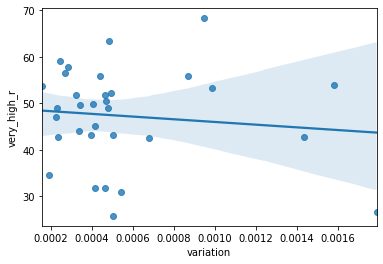

In [21]:
sns.regplot(x='variation', y='very_high_r', data=gb_cnts_local)

In [22]:
gb_cnts_local.corr(method='spearman')

,very_high_r,very_low_r,single_bid,file_size,person,contract_duration,daily_price,same_state,amount,variation
very_high_r,1.000000,-0.552870,0.314207,-0.287865,-0.370486,0.305591,0.233547,0.026214,0.385151,-0.092759
very_low_r,-0.552870,1.000000,-0.340335,-0.017882,0.256172,-0.217498,-0.052855,-0.168142,-0.098344,0.289874
single_bid,0.314207,-0.340335,1.000000,-0.048571,0.085777,0.086877,-0.285557,-0.302786,-0.324780,-0.025293
file_size,-0.287865,-0.017882,-0.048571,1.000000,-0.266771,0.086575,0.118091,-0.393575,0.014089,-0.251940
person,-0.370486,0.256172,0.085777,-0.266771,1.000000,-0.108871,-0.439883,0.118402,-0.749267,-0.151393
contract_duration,0.305591,-0.217498,0.086877,0.086575,-0.108871,1.000000,-0.082478,-0.033724,0.218109,-0.062683
daily_price,0.233547,-0.052855,-0.285557,0.118091,-0.439883,-0.082478,1.000000,-0.050953,0.726906,0.292889
same_state,0.026214,-0.168142,-0.302786,-0.393575,0.118402,-0.033724,-0.050953,1.000000,-0.119135,-0.281158
amount,0.385151,-0.098344,-0.324780,0.014089,-0.749267,0.218109,0.726906,-0.119135,1.000000,0.368035
variation,-0.092759,0.289874,-0.025293,-0.251940,-0.151393,-0.062683,0.292889,-0.281158,0.368035,1.000000


# Supplier variability

## Federal

## Coefficient of variation

In [23]:
gb_states = cnts_federal.groupby('supplier_state')['buyer_state'].value_counts().rename('N').reset_index()
gb_states_n = cnts_federal.groupby('supplier_state').buyer_state.size().rename('NC').reset_index()
gb_states = gb_states[
    gb_states.buyer_state != gb_states.supplier_state].groupby(
    'supplier_state').N.apply(dispersion).rename('variation_s').reset_index()
gb_states = pd.merge(gb_states, gb_states_n, how='left')
gb_states['variation_s'] = gb_states['variation_s'] / gb_states['NC']
gb_states = gb_states.drop('NC', axis=1)

In [27]:
gb_states = gb_states.set_index('supplier_state')

In [28]:
gb_cnts_federal = pd.merge(gb_cnts_federal, gb_states, how='left', left_on='state', right_index=True)

## Local

# Local Level

## Coefficient of variation

In [29]:
gb_states = cnts_local.groupby('supplier_state')['buyer_state'].value_counts().rename('N').reset_index()
gb_states_n = cnts_local.groupby('supplier_state').buyer_state.size().rename('NC').reset_index()
gb_states = gb_states[
    gb_states.buyer_state != gb_states.supplier_state].groupby(
    'supplier_state').N.apply(dispersion).rename('variation_s').reset_index()
gb_states = pd.merge(gb_states, gb_states_n, how='left')
gb_states['variation_s'] = gb_states['variation_s'] / gb_states['NC']
gb_states = gb_states.drop('NC', axis=1)

In [30]:
gb_states = gb_states.set_index('supplier_state')

In [31]:
gb_cnts_local = pd.merge(gb_cnts_local, gb_states, how='left', left_on='state', right_index=True)

# TAI

Transparencia, Anticorrupcion e impunidad cero.

In [19]:
states = ['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Chiapas', 'Chihuahua', 'Ciudad de México',
       'Coahuila de Zaragoza', 'Colima', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'Michoacán de Ocampo', 'Morelos',
       'México', 'Nayarit', 'Nuevo León', 'Oaxaca', 'Puebla', 'Querétaro',
       'Quintana Roo', 'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco',
       'Tamaulipas', 'Tlaxcala', 'Veracruz de Ignacio de la Llave',
       'Yucatán', 'Zacatecas']

In [20]:
codes = ['AGS',
         'BC',
         'BCS',
         'CAMP',
         'CHIS',
         'CHIH',
         'CDMX',
         'COAH',
         'COL',
         'DGO',
         'GTO',
         'GRO',
         'HGO',
         'JAL',
         'MICH',
         'MOR',
         'MEX',
         'NAY',
         'NL',
         'OAX',
         'PUE',
         'QRO',
         'QROO',
         'SLP',
         'SIN',
         'SON',
         'TAB',
         'TAM',
         'TLAX',
         'VER',
         'YUC',
         'ZAC']
dict_codes = dict(zip(codes, states))

In [21]:
tai = pd.read_csv('/home/rdora/declaranet/data/tables/transparencia_anticorrupcion_impunidad_agosto_2017.csv')

In [22]:
tai['state'] = tai['ENT'].replace(dict_codes)

In [23]:
tai = tai[['state', 'MT2014',
          'ICBG2015', 'INC2015', 'SOBPROM2015',
       'IGI2016', 'GA2017', 'TAI2017']]

In [24]:
gb_tai = pd.merge(gb_cnts, tai, how='left')

NameError: name 'gb_cnts' is not defined

# Encrig 2016

# Federal

In [33]:
file = '/home/rdora/declaranet/data/corruption/encrige_2016.csv'

cols = ['state',
        'sample',
        'c_very_high',
        'c_very_high_r',
        'c_high',
        'c_high_r',
        'c_low',
        'c_low_r']

df = pd.read_csv(file, usecols=[0, 1, 3, 4, 6, 7, 9, 10])
df.columns = cols
df['state'] = df.state.replace({'Querétaro de Arteaga': 'Querétaro',
                                'Distrito Federal': 'Ciudad de México',
                                'Estado de México': 'México'})

In [34]:
gb_cnts_federal = pd.merge(gb_cnts_federal, df[['state', 'c_very_high_r', 'c_low_r']], how='left')

In [35]:
gb_cnts_federal.corr(method='spearman')

,very_high_r,very_low_r,single_bid,file_size,person,contract_duration,daily_price,same_state,amount,variation,variation_s,c_very_high_r,c_low_r
very_high_r,1.000000,-0.552870,0.190284,0.231412,0.057745,-0.113657,0.085793,0.154720,0.296609,-0.435747,-0.431347,0.726856,-0.473182
very_low_r,-0.552870,1.000000,-0.138676,0.000738,-0.150830,-0.067404,0.030203,-0.349175,-0.336652,0.429839,0.387297,-0.745865,0.569869
single_bid,0.190284,-0.138676,1.000000,0.223385,-0.276393,-0.630499,-0.032258,0.052786,-0.440616,-0.616569,-0.515029,0.131232,0.006967
file_size,0.231412,0.000738,0.223385,1.000000,-0.316814,-0.288730,-0.129222,-0.310757,-0.318649,-0.175110,-0.102790,0.124449,0.143762
person,0.057745,-0.150830,-0.276393,-0.316814,1.000000,0.258065,-0.174120,0.181452,0.230205,0.339809,0.418622,0.093475,-0.116784
contract_duration,-0.113657,-0.067404,-0.630499,-0.288730,0.258065,1.000000,0.038123,0.129765,0.368402,0.378666,0.277859,0.024560,-0.111101
daily_price,0.085793,0.030203,-0.032258,-0.129222,-0.174120,0.038123,1.000000,-0.102639,0.538490,-0.109971,-0.170455,0.086144,-0.153268
same_state,0.154720,-0.349175,0.052786,-0.310757,0.181452,0.129765,-0.102639,1.000000,0.251833,-0.277126,-0.379399,0.417889,-0.537354
amount,0.296609,-0.336652,-0.440616,-0.318649,0.230205,0.368402,0.538490,0.251833,1.000000,0.026393,-0.046554,0.336144,-0.406087
variation,-0.435747,0.429839,-0.616569,-0.175110,0.339809,0.378666,-0.109971,-0.277126,0.026393,1.000000,0.837243,-0.536657,0.435420


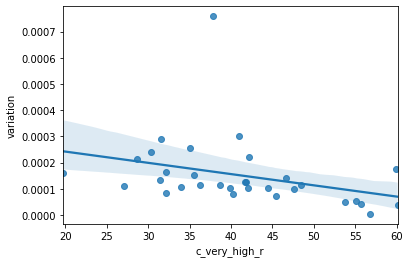

In [36]:
sns.regplot(x='c_very_high_r', y='variation', data=gb_cnts_federal)

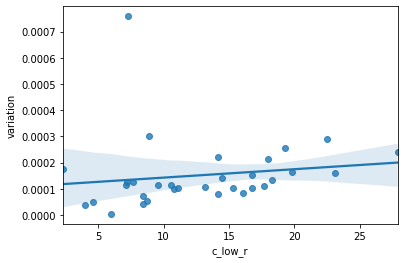

In [37]:
sns.regplot(x='c_low_r', y='variation', data=gb_cnts_federal)

## Local

In [38]:
gb_cnts_local = pd.merge(gb_cnts_local, df[['state', 'c_very_high_r', 'c_low_r']], how='left')

In [209]:
gb_cnts_local.corr(method='spearman')

,very_high_r,very_low_r,single_bid,file_size,person,contract_duration,daily_price,same_state,amount,variation,c_very_high_r,c_low_r
very_high_r,1.000000,-0.552870,0.314207,-0.287865,-0.370486,0.305591,0.233547,0.026214,0.385151,-0.092759,0.726856,-0.473182
very_low_r,-0.552870,1.000000,-0.340335,-0.017882,0.256172,-0.217498,-0.052855,-0.168142,-0.098344,0.289874,-0.745865,0.569869
single_bid,0.314207,-0.340335,1.000000,-0.048571,0.085777,0.086877,-0.285557,-0.302786,-0.324780,-0.025293,0.086510,0.049684
file_size,-0.287865,-0.017882,-0.048571,1.000000,-0.266771,0.086575,0.118091,-0.393575,0.014089,-0.251940,-0.051167,-0.052108
person,-0.370486,0.256172,0.085777,-0.266771,1.000000,-0.108871,-0.439883,0.118402,-0.749267,-0.151393,-0.459677,0.321936
contract_duration,0.305591,-0.217498,0.086877,0.086575,-0.108871,1.000000,-0.082478,-0.033724,0.218109,-0.062683,0.116202,-0.143001
daily_price,0.233547,-0.052855,-0.285557,0.118091,-0.439883,-0.082478,1.000000,-0.050953,0.726906,0.292889,0.440616,-0.390320
same_state,0.026214,-0.168142,-0.302786,-0.393575,0.118402,-0.033724,-0.050953,1.000000,-0.119135,-0.281158,0.171554,-0.229352
amount,0.385151,-0.098344,-0.324780,0.014089,-0.749267,0.218109,0.726906,-0.119135,1.000000,0.368035,0.449413,-0.348886
variation,-0.092759,0.289874,-0.025293,-0.251940,-0.151393,-0.062683,0.292889,-0.281158,0.368035,1.000000,-0.236437,0.203502


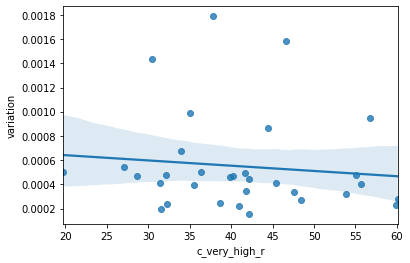

In [39]:
sns.regplot(x='c_very_high_r', y='variation', data=gb_cnts_local)

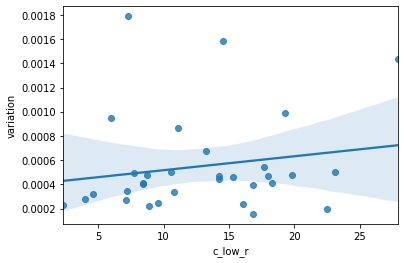

In [211]:
sns.regplot(x='c_low_r', y='variation', data=gb_cnts_local)

# Corruption Experience

# Federal

In [40]:
file = '/home/rdora/declaranet/data/corruption/corruption_experience_2017.csv'

cols = ['state',
        'sample',
        'e_heard',
        'e_heard_r',
        'e_known',
        'e_known_r',
        'e_exp',
        'e_exp_r']

df = pd.read_csv(file, usecols=[0, 1, 3, 4, 6, 7, 9, 10], names=cols)
df['state'] = df.state.replace({'Querétaro de Arteaga': 'Querétaro',
                                'Distrito Federal': 'Ciudad de México',
                                'Estado de México': 'México'})
df.iloc[:, 1:] = df.iloc[:, 1:].apply(lambda x: x.str.replace("\s", ""), axis=1)


df[cols[1:]] = df[cols[1:]].astype(float)

In [41]:
gb_cnts_federal = pd.merge(gb_cnts_federal, df[['state', 'e_exp_r']], how='left')

In [42]:
gb_cnts_federal.to_csv("/home/rdora/declaranet/data/states/federal.csv", index=False)

# Local

In [43]:
gb_cnts_local = pd.merge(gb_cnts_local, df[['state', 'e_exp_r']], how='left')

In [44]:
gb_cnts_local.to_csv("/home/rdora/declaranet/data/states/local.csv", index=False)

# Coefficient of Variation across buyers and suppliers

## Buyer

# Federal

In [49]:
gb_states = cnts_federal.groupby('buyer')['supplier'].value_counts().rename('N').reset_index()
gb_states_n = cnts_federal.groupby('buyer').supplier.size().rename('NC').reset_index()
gb_states = gb_states.groupby(
    'buyer').N.apply(dispersion).rename('variation_buyer').reset_index()
gb_states = pd.merge(gb_states, gb_states_n, how='left')
gb_states['variation_buyer'] = gb_states['variation_buyer'] / gb_states['NC']
gb_states = gb_states.drop('NC', axis=1)

In [53]:
cnts_federal = pd.merge(cnts_federal, gb_states)

In [64]:
gb_states = cnts_federal.groupby(['buyer_state']).variation_buyer.mean().reset_index().set_index('buyer_state')

In [66]:
gb_cnts_federal = pd.merge(gb_cnts_federal,
                          gb_states,
                          how="left",
                          left_on="state",
                          right_index=True)

## Local

In [68]:
gb_states = cnts_local.groupby('buyer')['supplier'].value_counts().rename('N').reset_index()
gb_states_n = cnts_local.groupby('buyer').supplier.size().rename('NC').reset_index()
gb_states = gb_states.groupby(
    'buyer').N.apply(dispersion).rename('variation_buyer').reset_index()
gb_states = pd.merge(gb_states, gb_states_n, how='left')
gb_states['variation_buyer'] = gb_states['variation_buyer'] / gb_states['NC']
gb_states = gb_states.drop('NC', axis=1)

In [69]:
cnts_local = pd.merge(cnts_local, gb_states)

In [70]:
gb_states = cnts_local.groupby(['buyer_state']).variation_buyer.mean().reset_index().set_index('buyer_state')

In [71]:
gb_cnts_local = pd.merge(gb_cnts_local,
                          gb_states,
                          how="left",
                          left_on="state",
                          right_index=True)

## Supplier

# Federal

In [74]:
gb_states = cnts_federal.groupby('supplier')['buyer'].value_counts().rename('N').reset_index()
gb_states_n = cnts_federal.groupby('supplier').buyer.size().rename('NC').reset_index()
gb_states = gb_states.groupby(
    'supplier').N.apply(dispersion).rename('variation_supplier').reset_index()
gb_states = pd.merge(gb_states, gb_states_n, how='left')
gb_states['variation_supplier'] = gb_states['variation_supplier'] / gb_states['NC']
gb_states = gb_states.drop('NC', axis=1)

In [75]:
cnts_federal = pd.merge(cnts_federal, gb_states)

In [92]:
gb_states = cnts_federal.groupby(['buyer_state']).variation_supplier.mean().reset_index().set_index('buyer_state')

In [93]:
gb_cnts_federal = pd.merge(gb_cnts_federal,
                          gb_states,
                          how="left",
                          left_on="state",
                          right_index=True)

In [94]:
gb_cnts_federal.corr()

,very_high_r,very_low_r,single_bid,file_size,person,contract_duration,daily_price,same_state,amount,variation,variation_s,c_very_high_r,c_low_r,e_exp_r,variation_buyer,variation_supplier
very_high_r,1.000000,-0.576909,0.211702,0.158444,-0.000814,-0.210743,0.071124,0.241425,0.384623,-0.507584,-0.328799,0.717764,-0.482297,0.399568,0.255029,-0.219857
very_low_r,-0.576909,1.000000,-0.142600,-0.071038,-0.137776,0.076133,-0.058770,-0.369632,-0.314936,0.314617,0.233265,-0.703466,0.525761,-0.116780,0.026356,0.055706
single_bid,0.211702,-0.142600,1.000000,0.142081,-0.081702,-0.492857,-0.084036,0.154874,-0.164010,-0.402719,-0.435569,0.181580,-0.092560,-0.017234,0.240091,-0.300011
file_size,0.158444,-0.071038,0.142081,1.000000,-0.288652,-0.309771,-0.021444,-0.187809,-0.264751,-0.197264,-0.085107,0.186048,0.024914,0.217873,-0.012154,-0.701593
person,-0.000814,-0.137776,-0.081702,-0.288652,1.000000,0.121637,0.044044,0.144027,0.038982,0.098257,0.343860,0.075545,-0.142000,-0.112440,-0.239691,0.284941
contract_duration,-0.210743,0.076133,-0.492857,-0.309771,0.121637,1.000000,0.254997,0.019553,0.253590,0.626075,0.344275,-0.020633,-0.142452,-0.169390,0.010561,0.456242
daily_price,0.071124,-0.058770,-0.084036,-0.021444,0.044044,0.254997,1.000000,-0.034270,0.436287,0.162062,0.255551,0.048458,-0.090916,-0.117548,0.082078,-0.109216
same_state,0.241425,-0.369632,0.154874,-0.187809,0.144027,0.019553,-0.034270,1.000000,0.264586,-0.320424,-0.387260,0.417301,-0.487391,0.090716,-0.206457,0.224144
amount,0.384623,-0.314936,-0.164010,-0.264751,0.038982,0.253590,0.436287,0.264586,1.000000,-0.037006,-0.081911,0.370222,-0.364302,0.457601,0.186177,0.113702
variation,-0.507584,0.314617,-0.402719,-0.197264,0.098257,0.626075,0.162062,-0.320424,-0.037006,1.000000,0.773432,-0.326842,0.149603,-0.155543,-0.003822,0.234426


## Local

In [78]:
gb_states = cnts_local.groupby('supplier')['buyer'].value_counts().rename('N').reset_index()
gb_states_n = cnts_local.groupby('supplier').buyer.size().rename('NC').reset_index()
gb_states = gb_states.groupby(
    'supplier').N.apply(dispersion).rename('variation_supplier').reset_index()
gb_states = pd.merge(gb_states, gb_states_n, how='left')
gb_states['variation_supplier'] = gb_states['variation_supplier'] / gb_states['NC']
gb_states = gb_states.drop('NC', axis=1)

In [79]:
cnts_local = pd.merge(cnts_local, gb_states)

In [95]:
gb_states = cnts_local.groupby(['buyer_state']).variation_supplier.mean().reset_index().set_index('buyer_state')

In [96]:
gb_cnts_local = pd.merge(gb_cnts_local,
                          gb_states,
                          how="left",
                          left_on="state",
                          right_index=True)

In [97]:
gb_cnts_local.corr()

,very_high_r,very_low_r,single_bid,file_size,person,contract_duration,daily_price,same_state,amount,variation,variation_s,c_very_high_r,c_low_r,e_exp_r,variation_buyer,variation_supplier
very_high_r,1.000000,-0.576909,0.290911,-0.393933,-0.296438,0.113072,0.246894,0.162241,0.314951,-0.112062,-0.463572,0.717764,-0.482297,0.399568,0.255029,-0.192642
very_low_r,-0.576909,1.000000,-0.345076,0.175071,0.146028,-0.154314,0.047347,-0.178594,-0.109769,0.179178,0.372444,-0.703466,0.525761,-0.116780,0.026356,0.218784
single_bid,0.290911,-0.345076,1.000000,-0.017818,0.065941,-0.068373,-0.341266,-0.249746,-0.230719,0.119027,-0.230028,0.108772,0.101826,-0.038007,0.169727,-0.330602
file_size,-0.393933,0.175071,-0.017818,1.000000,-0.134549,0.060189,-0.085474,-0.393161,-0.143646,-0.285660,-0.092429,-0.207006,0.190575,-0.014832,-0.310567,-0.160773
person,-0.296438,0.146028,0.065941,-0.134549,1.000000,-0.011050,-0.381186,0.174803,-0.580185,-0.044982,0.182813,-0.362334,0.224801,-0.323352,-0.173084,0.240093
contract_duration,0.113072,-0.154314,-0.068373,0.060189,-0.011050,1.000000,-0.133219,0.089886,0.072976,-0.182922,-0.187164,-0.009488,-0.100101,0.046713,-0.151842,0.228652
daily_price,0.246894,0.047347,-0.341266,-0.085474,-0.381186,-0.133219,1.000000,-0.003593,0.705785,0.016886,-0.029020,0.381621,-0.334625,0.279889,-0.010364,-0.013495
same_state,0.162241,-0.178594,-0.249746,-0.393161,0.174803,0.089886,-0.003593,1.000000,0.023127,-0.372393,-0.391333,0.166866,-0.248688,-0.071104,-0.189042,0.363621
amount,0.314951,-0.109769,-0.230719,-0.143646,-0.580185,0.072976,0.705785,0.023127,1.000000,0.184388,-0.068186,0.359744,-0.330904,0.345475,0.196239,-0.194839
variation,-0.112062,0.179178,0.119027,-0.285660,-0.044982,-0.182922,0.016886,-0.372393,0.184388,1.000000,0.696636,-0.109319,0.177052,0.049447,0.178875,-0.445979
